In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
import pickle
from PIL import Image
import time
import os
from PIL import Image
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

# from sklearn.model_selection import KFold

start = time.time()

# Variables

In [2]:
## variables for the fiddling with (99% val_acc with .0339 val_loss)

dim = (176,208)               # input image dimensions                                              (176,208)
test_split_percent = .1       # % of total data for testing                                         .1
validation_split_percent = .2 # % of total data for validation                                      .2
zoom = [.99,1.01]             # zoom range (for a fixed zoom put the same value in both parameters)[.99,1.01]
bright_range = [.8,1.2]       # brightness range                                                    [.8,1.2] 
layers_unlocked = True        # unlock the imported pre-training layers?                            False  
lr = 0.0001                   # learning rate for optimizer                                         0.0001
batch = 20                    # batch size for model fitting                                        20
eps = 30                      # number of epochs to run                                             50
momentum = .9                 # momentum of SGD                                                     .9

save_model_name = "val%2d_epochs%d"%(validation_split_percent*100,eps)   # automatically generate a model save name
print(save_model_name)

# k_folds = 10                # number of folds for k-fold validation                              #k-folds someday

val20_epochs30


# Import Data From Local Drive

In [3]:
# This section uses the ImageDataGenerator and flow_from_directory functions to sort the images by label
#actual dimensions 176x208x1

# introduced zoom, blew up the image of the brain itself, and brightness range to adjust for different brightness
train_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,
                                                           brightness_range=bright_range,zoom_range=zoom,
                                                           data_format='channels_last',zca_whitening=False)

train_data_gen = train_dr.flow_from_directory(directory=r'C:\Users\srika\Dropbox\PC\Downloads\Detection Of Diabetic Retinopathy Using Machine Learning.v1-retinopath-dataset-1.folder\train',target_size=dim,
                                              batch_size=5000)

# Change to zoom = [1,1] to use normal test data
test_dr = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,fill_mode='constant',cval=0,zoom_range=[1,1],
                                                          data_format='channels_last') 
test_data_gen = test_dr.flow_from_directory(directory=r'C:\Users\srika\Dropbox\PC\Downloads\Detection Of Diabetic Retinopathy Using Machine Learning.v1-retinopath-dataset-1.folder\test',target_size=dim,batch_size=5000,
                                           shuffle = False) # test data should not be shuffled to keep labels

Found 5094 images belonging to 5 classes.
Found 360 images belonging to 5 classes.


In [4]:
# This section assigns the images to numpy arrays for the data and labels
# EX: train_data = numpy array of image data, train_labels = numpy array of labels 

train_data,train_labels =  train_data_gen.next()
test_data,test_labels = test_data_gen.next()

#val_data,val_labels = val_data_gen.next()

In [ ]:
import gc
gc.collect()

In [5]:
# cocatenate arrays, combining all data
total_data = np.concatenate((train_data,test_data))
total_labels = np.concatenate((train_labels,test_labels))
print(total_data.shape)
print(total_labels.shape)

(5360, 176, 208, 3)
(5360, 5)


In [6]:
# train test split

initial_split = test_split_percent+validation_split_percent
test_val_split = test_split_percent/initial_split

# split into training and (test + validation)
train_data, test_val_data, train_labels, test_val_labels = train_test_split(total_data,total_labels,
                                                                            test_size=initial_split)

# split (test + validation) into test and validation sets
test_data, val_data, test_labels, val_labels = train_test_split(test_val_data,test_val_labels,
                                                                test_size=test_val_split)

print('train: ',train_data.shape)
print('validation',val_data.shape)
print('test',test_data.shape)

train:  (3751, 176, 208, 3)
validation (537, 176, 208, 3)
test (1072, 176, 208, 3)


# Sanity Checks

In [7]:
# Check array dimensions
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(3751, 176, 208, 3)
(3751, 5)
(537, 176, 208, 3)
(537, 5)
(1072, 176, 208, 3)
(1072, 5)


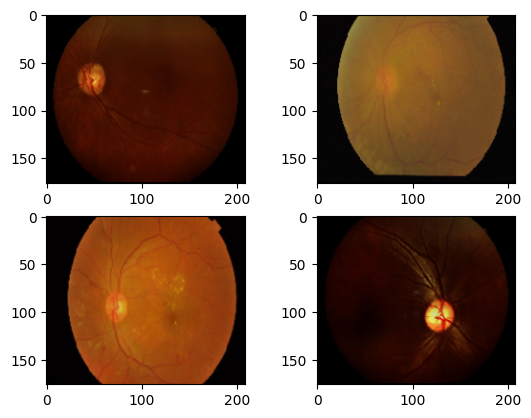

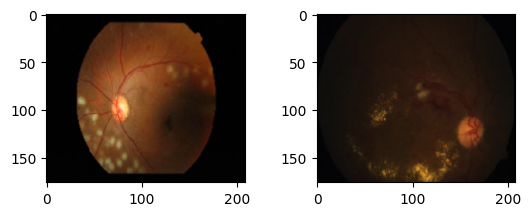

In [8]:
# check some images
plt.subplot(221)
plt.imshow(train_data[1,:,:,:])
plt.subplot(222)
plt.imshow(train_data[2,:,:,:])
plt.subplot(223)
plt.imshow(val_data[3,:,:,:])
plt.subplot(224)
plt.imshow(val_data[4,:,:,:])
plt.show()
plt.subplot(221)
plt.imshow(test_data[5,:,:,:])
plt.subplot(222)
plt.imshow(test_data[154,:,:,:])

In [9]:
# preprocess the images in the same manner as those trained on original model
#train_data = preprocess_input(train_data)
#val_data = preprocess_input(val_data)
#test_data = preprocess_input(test_data)
print(np.amax(train_data))
print(np.amin(train_data))
print(np.amax(val_data))
print(np.amin(val_data))

1.0
0.0
1.0
0.0


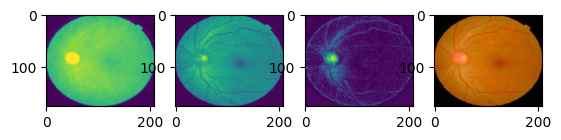

In [10]:
# check image channels
plt.subplot(141)
plt.imshow(train_data[3,:,:,0])
plt.subplot(142)
plt.imshow(train_data[3,:,:,1])
plt.subplot(143)
plt.imshow(train_data[3,:,:,2])
plt.subplot(144)
plt.imshow(train_data[3,:,:,:])

# Create Model
or to load a model, skip down to "Load Model", then you can either continue training that model by skipping the next cell, or jump to "Evaluate Model"

In [11]:
# import pre-trained VGG16 model
weight_path1 =r"C:\Users\srika\Dropbox\PC\Downloads\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
vg_model = tf.keras.applications.vgg16.VGG16(weights = weight_path1,include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling

## IF YOU LOADED A MODEL AND WANT TO CONTINUE TRAINING, comment above, uncomment below
# vg_model = vg_model(include_top=False,input_shape=(dim[0],dim[1],3), pooling = 'max') #added pooling

In [18]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Load pre-trained VGG16 model
vg_model = VGG16(weights='imagenet', include_top=False, input_shape=(176, 208, 3))

# Set the specified convolutional layers to be trainable
layers_unlocked = True
vg_model.get_layer('block1_conv1').trainable = layers_unlocked
vg_model.get_layer('block1_conv2').trainable = layers_unlocked
vg_model.get_layer('block2_conv1').trainable = layers_unlocked
vg_model.get_layer('block2_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv1').trainable = layers_unlocked
vg_model.get_layer('block3_conv2').trainable = layers_unlocked
vg_model.get_layer('block3_conv3').trainable = layers_unlocked
vg_model.get_layer('block4_conv1').trainable = layers_unlocked
vg_model.get_layer('block4_conv2').trainable = layers_unlocked
vg_model.get_layer('block4_conv3').trainable = layers_unlocked

# Set the last convolutional layers to be non-trainable
vg_model.get_layer('block5_conv1').trainable = False
vg_model.get_layer('block5_conv2').trainable = False
vg_model.get_layer('block5_conv3').trainable = False

# Add new trainable fully connected layers
flat = Flatten()(vg_model.output)
fc1 = Dense(1024, activation='relu', kernel_initializer='he_uniform')(flat)
dp1 = Dropout(0.25)(fc1)
output = Dense(5, activation='softmax')(dp1)  # Adjusted to softmax for multi-class classification
vg_model = Model(inputs=vg_model.inputs, outputs=output)

vg_model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 176, 208, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 176, 208, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 176, 208, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 88, 104, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 88, 104, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 88, 104, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 44, 52, 128)       0   

In [19]:
# compile the model
#changed from tf.keras.optimizers.Adam(learning_rate=.0001) to SGD+nest.+momentum
opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, nesterov=True,name='SGD') 

vg_model.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])

# Train the Model



In [20]:
batch_size = 16  # Reduce the batch size
model_history = vg_model.fit(train_data, train_labels, validation_data=(val_data, val_labels),
                            epochs=eps, batch_size=batch, shuffle=True)


Epoch 1/30
188/188 [==============================] - 34s 128ms/step - loss: 0.9302 - accuracy: 0.6684 - val_loss: 0.7914 - val_accuracy: 0.6965
Epoch 2/30
188/188 [==============================] - 21s 112ms/step - loss: 0.7729 - accuracy: 0.7193 - val_loss: 0.7606 - val_accuracy: 0.7151
Epoch 3/30
188/188 [==============================] - 21s 113ms/step - loss: 0.7026 - accuracy: 0.7462 - val_loss: 0.6868 - val_accuracy: 0.7467
Epoch 4/30
188/188 [==============================] - 21s 114ms/step - loss: 0.6551 - accuracy: 0.7587 - val_loss: 0.6927 - val_accuracy: 0.7430
Epoch 5/30
188/188 [==============================] - 22s 118ms/step - loss: 0.6223 - accuracy: 0.7715 - val_loss: 0.6322 - val_accuracy: 0.7598
Epoch 6/30
188/188 [==============================] - 23s 121ms/step - loss: 0.5899 - accuracy: 0.7873 - val_loss: 0.6370 - val_accuracy: 0.7654
Epoch 7/30
188/188 [==============================] - 23s 121ms/step - loss: 0.5672 - accuracy: 0.7937 - val_loss: 0.6083 - val_ac

In [21]:
scores = vg_model.evaluate(train_data, train_labels)
print("Accuracy: %.2f%%" %(scores[1]*100))

118/118 [==============================] - 9s 64ms/step - loss: 0.0918 - accuracy: 0.9744
Accuracy: 97.44%


# Plots and Values

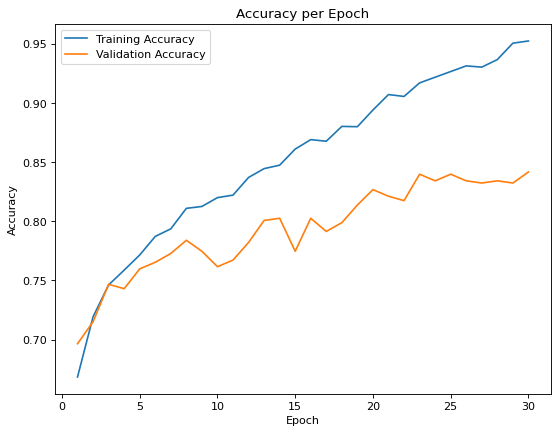

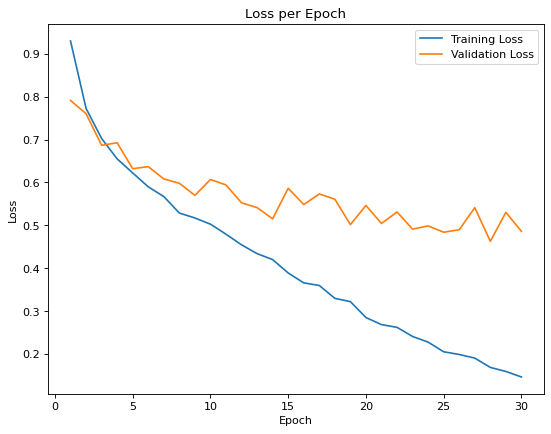

image dimensions:  (176, 208)
validation split percentage:  0.2
zoom:  [0.99, 1.01]
Learning Rate:  0.0001
batch size:  20
epochs:  30
brightness range:  [0.8, 1.2]
Model trained from scratch? :  True
Total Time Elapsed = 18 minutes


In [22]:
# plot accuracy

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('Accuracy per Epoch')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['accuracy'], label = 'Training Accuracy')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['val_accuracy'], label = 'Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
#print(np.amax.model_history.history['val_accuracy'])

#Plot loss
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title('Loss per Epoch')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['loss'], label = 'Training Loss')
plt.plot(np.linspace(1,eps,num=eps),model_history.history['val_loss'], label = 'Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# print out variable values
print('image dimensions: ',dim)
print('validation split percentage: ',validation_split_percent)
print('zoom: ',zoom)
print('Learning Rate: ',lr)
print('batch size: ',batch)
print('epochs: ',eps)
print('brightness range: ',bright_range)
print('Model trained from scratch? : ',layers_unlocked)
end = time.time()
print('Total Time Elapsed = %.2d minutes'%((end - start)/60))

# Performance Evaluation
Come here after loading model

In [23]:
### PERFORMANCE EVALUATION ##
train_scores = vg_model.evaluate(train_data, train_labels)
val_scores = vg_model.evaluate(val_data,val_labels)
test_scores = vg_model.evaluate(test_data, test_labels)

print('Train Accuracy: %.2f%%'%(train_scores[1]*100))
print('Validation Accuracy: %.2f%%'%(val_scores[1]*100))
print('Test Accuracy: %.2f%%'%(test_scores[1]*100))

34/34 [==============================] - 3s 76ms/step - loss: 0.5298 - accuracy: 0.8330
Train Accuracy: 97.44%
Validation Accuracy: 84.17%
Test Accuracy: 83.30%


# Saving the Model

In [25]:
## saving in HDF5 format
save_name = '%s_retina%2d.h5'%(save_model_name,(test_scores[1]*100))
vg_model.save("C:/Users/srika/Dropbox/PC/Downloads/%s"%save_name)
print(save_name)


## save the model_history


val20_epochs30_retina83.h5


# Load Model

In [31]:
## choose the model to load ##
## comment out when not using ##

vg_model.save('C:/Users/srika/Dropbox/PC/Downloads/alz/Alzheimer_s Dataset/val20_epochs30_testacc94.h5')